<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_10_In_hospital_Mortality_Prediction_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: In-hospital Mortality Prediction (Cont'd)

## Setup

**Packages for data handling and visualization**

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

**Packages for data analysis and modelling**

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, plot_confusion_matrix, plot_roc_curve, mean_squared_error, r2_score

**Authenication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in Week 5 notebook, grant Colab access to your Google Drive and import it to the current notebook. You would need to authenicate yourself. 

Alternatively, when you are working on your own analysis, you may also put everything (i.e. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment. 


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   IN_HOSP_DEATH                     58976 non-null  int64  
 7   DIAGNOSIS                         58951 non-null  object 
 8   MARITAL_STATUS                    58976 non-null  object 
 9   INSURANCE                         58976 non-null  object 
 10  LANGUAGE                          58976 non-null  object 
 11  RELIGION                          58976 non-null  object 
 12  ETHN

In [ ]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11 00:00:00,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,0,MVA;TRAUMA,SINGLE,Government,ENGL,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,18,11.112500,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2096-08-27 00:00:00,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,70,13.895833,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29 00:00:00,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,90,5.634722,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16 00:00:00,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,76,5.585417,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0


`IN_HOSP_DEATH` would be our prediction target. Here, let's define a list of 38 column names for features/inputs we would use in the model as not all columns are appropriate (e.g. `SUBJECT_ID`). 

In [ ]:
features_list = ['GENDER_F', 'AGE', 'LOS', 'LOS_ICU', 
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY', 
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS', 
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

38

In [ ]:
X = df[features_list]
y = df['IN_HOSP_DEATH']

## Train-test Split

* Help mitigate overfitting (model learns to fit the noise and error terms of the data) while we train machine learning models
* Allow us to report an unbiased performance metric using data unseen by the model
* A 70-30 or 80-20 split is usually the most common. 

![](https://miro.medium.com/max/694/1*tBErXYVvTw2jSUYK7thU2A.png)

([Source](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,  # 20% of data belongs to the test set
                                                    random_state = 1, # make sure the split is the same across different devices for illustrative purposes
                                                    stratify = y)     # ensure the number of positive examples in the train and test sets are similar

In [ ]:
X_train.shape

(47180, 38)

In [ ]:
X_test.shape

(11796, 38)

As a result, our training and test set would include 47,180 and 11,796 admissions respectively. 

## Logistic Regression

In this example, we would be utilizing the package package [Scikit-learn](https://scikit-learn.org/stable/user_guide.html) heavily for modelling. In Scikit-learn, the general flow can be simplified as follows:

1. Specify a model to be trained
  * Choose a type of model based on your task and dataset. A full list of available models in the package can be found [here](https://scikit-learn.org/stable/modules/classes.html).
  * Set the hyperparameters of the model. 
  * Assign the model to a variable.
2. Train the model
  * Call the `.fit()` function using your cleaned train dataset.
3. Make predictions
  * Call the `.predict()` function using your cleaned test dataset.

### Model Training and Prediction

In [ ]:
# 1. Specify a model to be trained
model_lr = LogisticRegression(random_state = 1, 
                              n_jobs = -1) # use all available CPUs within your Colab notebook for computation

In [ ]:
# 2. Train the model
model_lr.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=1)

In [ ]:
# 3. Make predictions
y_pred_lr = model_lr.predict(X_test)
y_pred_lr

array([1, 0, 0, ..., 0, 0, 0])

Use `.predict_proba()` instead if you want probabilistic outputs over class outputs. 

In [ ]:
model_lr.predict_proba(X_test) # the two columns represent the prob of 0 and 1 respectively 

array([[0.27561257, 0.72438743],
       [0.98961611, 0.01038389],
       [0.94710806, 0.05289194],
       ...,
       [0.86003954, 0.13996046],
       [0.98685631, 0.01314369],
       [0.93034924, 0.06965076]])

### Evaluation

There are several metrics for evaluating the binary classification performances. In general, F1-score, being the harmonic mean of precision and recall, is the most common metric for these kind of machine learning problems.  

![binary classification metrics](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)

([Source](https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html))

In [ ]:
accuracy_score(y_test, y_pred_lr)

0.9261614106476772

In [ ]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     10625
           1       0.81      0.34      0.48      1171

    accuracy                           0.93     11796
   macro avg       0.87      0.66      0.72     11796
weighted avg       0.92      0.93      0.91     11796



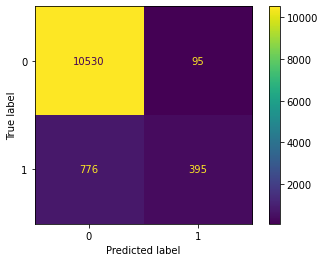

In [ ]:
plot_confusion_matrix(model_lr, X_test, y_test, values_format = 'd')
plt.show()

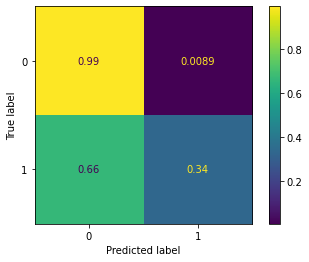

In [ ]:
# recall-related metrics
plot_confusion_matrix(model_lr, X_test, y_test, normalize = 'true') 
plt.show()

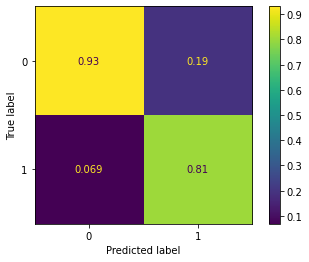

In [ ]:
# precision-related metrics
plot_confusion_matrix(model_lr, X_test, y_test, normalize = 'pred')
plt.show()

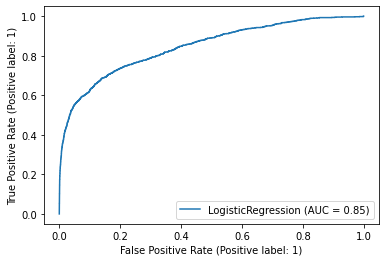

In [ ]:
plot_roc_curve(model_lr, X_test, y_test)
plt.show()

**Observations**

* Despite having an accuracy of 92.6%, the overall F1-score is around 48%. The high accuracy is due to class imbalance and the model predicted the majority class (`IN_HOSP_DEATH == 0`) correctly. 
* The recall for the positive examples is 34%, meaning that only around one-third of those who died within their hospital stay is successfully detected by the model.

## Random Forest Model

![Random Forest](https://cdn.analyticsvidhya.com/wp-content/uploads/2020/02/rfc_vs_dt1.png)

([Source](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/))

### Model Training and Prediction


Define the configuration/hyperparameters of a random forest model. Here we specify that the model contains 200 decision trees.

In [ ]:
model_rf1 = RandomForestClassifier(n_estimators = 200, 
                                   random_state = 1,
                                   n_jobs = -1)

In [ ]:
model_rf1.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=1)

In [ ]:
y_pred_rf1 = model_rf1.predict(X_test)

### Evaluation

In [ ]:
print(classification_report(y_test, y_pred_rf1))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     10625
           1       0.86      0.45      0.59      1171

    accuracy                           0.94     11796
   macro avg       0.90      0.72      0.78     11796
weighted avg       0.93      0.94      0.93     11796



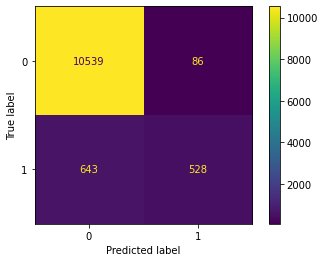

In [ ]:
plot_confusion_matrix(model_rf1, X_test, y_test, values_format = 'd')
plt.show()

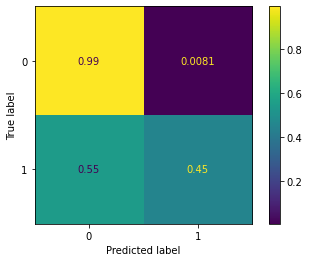

In [ ]:
plot_confusion_matrix(model_rf1, X_test, y_test, normalize = 'true') # recall
plt.show()

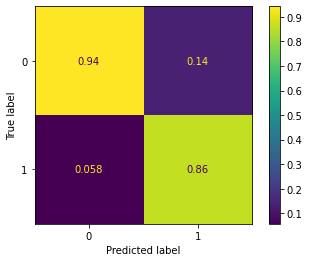

In [ ]:
plot_confusion_matrix(model_rf1, X_test, y_test, normalize = 'pred') # precision
plt.show()

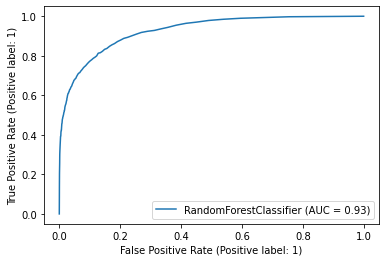

In [ ]:
plot_roc_curve(model_rf1, X_test, y_test)

## Tuning Random Forest Model

Now, we try to **tune the hyperparameters** of the random forest model above based on cross-validation and grid search. We apply the `GridSearchCV()` function and specify a list of hyperparameters and their respective values to be tested. Models are trained for each combination of values and fold. The best performing set of hyperparameters across all folds would then be reported and used. 

![train-validation-test split](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

([Source](https://scikit-learn.org/stable/))

---

Performing this step requires at least a basic understanding on the meaning and effect of each hyperparameter. You should always refer to the docs of the model you are using in this step ([RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) in this case). An explanation of Random Forest hyperparameters can also be found [here](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/).


In [ ]:
# a set of hyperparameters and their respective values to be tested

param_grid = {
    'n_estimators': [100, 200, 300],   # number of decision trees in the forest 
    'max_depth': [10, 40, None],       # how many times can each tree be split. None means no specific limit. 
    'class_weight': ['balanced', None] # weight of each sample. None means equal weight, balanced would put more weight on the less represented classes
}

In [ ]:
grid_search_rf = GridSearchCV(
    estimator = RandomForestClassifier(random_state = 1, n_jobs = -1), # define type of model to be tuned
    param_grid = param_grid,                                           # hyperparameters to be tested
    cv = 3,                                                            # 3-fold cross-validation
    scoring = 'f1',                                                    # metric to be optimized
    n_jobs = -1, 
    verbose = 2
    )

In [ ]:
grid_search_rf.fit(X_train, y_train)

# this would take 10 to 15 minutes to run
# this could take even longer depending on the number of hyperparameters to be tested, number of folds or the size of the dataset

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=1),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [10, 40, None],
                         'n_estimators': [100, 200, 300]},
             scoring='f1', verbose=2)

### Tuning Results

Retrieve the best performing set of hyperparams using `.best_params_`

In [ ]:
grid_search_rf.best_params_

{'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 300}

Retrieve the best performing model using `.best_estimator_` and save it as a seperate variable.

In [ ]:
model_rf2 = grid_search_rf.best_estimator_

In [ ]:
model_rf2

# Note: this would be the same as training a seperate model using the same inputs, i.e.
# model_rf2 = RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
#                                    n_jobs=-1, random_state=1)
# model_rf2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                       n_jobs=-1, random_state=1)

Use `.cv_results_` in case you want to look into the details of each set of hyperparams. This could help you determine the apprioriate range of each hyperparameter, and thus setting up better `param_grid`'s in any subsequent tuning using more refined ranges. For exampleIn the example below, it appears that having a `max_depth` of 10 is better than both 40 and `None`.

In [ ]:
pd.DataFrame(grid_search_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.866797,0.203686,0.563543,0.007106,balanced,10,100,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.598391,0.601504,0.609319,0.603071,0.004597,3
1,13.866476,0.082146,1.019776,0.054300,balanced,10,200,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.601622,0.600324,0.609776,0.603907,0.004184,2
2,20.697762,0.228885,1.291654,0.105222,balanced,10,300,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.605078,0.601989,0.610927,0.605998,0.003707,1
3,9.690306,0.191491,0.622531,0.058136,balanced,40,100,"{'class_weight': 'balanced', 'max_depth': 40, ...",0.566970,0.577417,0.556177,0.566855,0.008671,15
4,19.121491,0.325246,1.151203,0.084222,balanced,40,200,"{'class_weight': 'balanced', 'max_depth': 40, ...",0.574614,0.579846,0.562500,0.572320,0.007265,11
5,27.818944,0.051675,1.781902,0.076243,balanced,40,300,"{'class_weight': 'balanced', 'max_depth': 40, ...",0.575085,0.575835,0.556701,0.569207,0.008849,13
6,9.384119,0.036329,0.614783,0.040409,balanced,None,100,"{'class_weight': 'balanced', 'max_depth': None...",0.566970,0.578272,0.556177,0.567140,0.009021,14
7,18.876429,0.313128,1.191651,0.047665,balanced,None,200,"{'class_weight': 'balanced', 'max_depth': None...",0.574614,0.581197,0.562500,0.572770,0.007743,10
8,27.631272,0.274998,1.792615,0.043128,balanced,None,300,"{'class_weight': 'balanced', 'max_depth': None...",0.575085,0.576445,0.556701,0.569411,0.009004,12
9,7.067659,0.178870,0.554796,0.080916,None,10,100,"{'class_weight': None, 'max_depth': 10, 'n_est...",0.561465,0.564767,0.552115,0.559449,0.005358,18


### Evaluation

In [ ]:
y_pred_rf2 = model_rf2.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_rf2))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94     10625
           1       0.51      0.72      0.59      1171

    accuracy                           0.90     11796
   macro avg       0.74      0.82      0.77     11796
weighted avg       0.92      0.90      0.91     11796



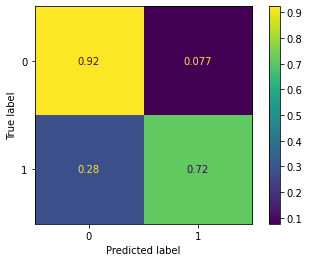

In [ ]:
plot_confusion_matrix(model_rf2, X_test, y_test, normalize = 'true') # recall
plt.show()

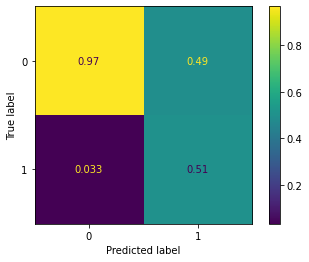

In [ ]:
plot_confusion_matrix(model_rf2, X_test, y_test, normalize = 'pred') # precision
plt.show()

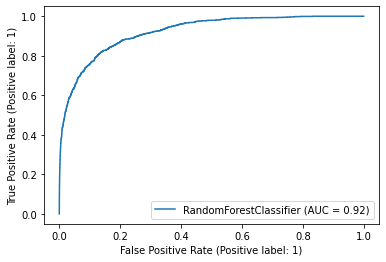

In [ ]:
plot_roc_curve(model_rf2, X_test, y_test)

**Observations**

* The AUC (0.93 vs 0.92), accuracy (0.94 vs 0.9) and F1-scores (0.78 vs 0.77) of the untuned and tuned model are comparable. 
* The overall recall of the tuned model is remarkably higher (72% vs 82%). In particular, 72% of those who died within their hospital stay is successfully detected by the model.

### Understanding the model

One major strength of tree-based machine learning models is its inherent ability to report feature importance. This could be useful to finding insights in the model.

In [ ]:
model_rf2_importance = pd.Series(model_rf2.feature_importances_, index = features_list)
model_rf2_importance

GENDER_F                            0.001732
AGE                                 0.060737
LOS                                 0.067318
LOS_ICU                             0.045185
CALLOUT_COUNT_DAY                   0.073024
PRES_COUNT_DAY                      0.051393
PROC_COUNT_DAY                      0.031713
CPT_COUNT_DAY                       0.091913
LAB_COUNT_DAY                       0.204541
INPUTS_CV_COUNT_DAY                 0.070303
INPUTS_MV_COUNT_DAY                 0.026246
OUTPUT_COUNT_DAY                    0.042628
TRANSFER_COUNT_DAY                  0.027193
MICRO_COUNT_DAY                     0.109172
ADMISSION_TYPE_ELECTIVE             0.009640
ADMISSION_TYPE_EMERGENCY            0.032882
ADMISSION_TYPE_NEWBORN              0.010117
ADMISSION_TYPE_URGENT               0.001607
RELIGION_CATHOLIC                   0.001523
RELIGION_NOT SPECIFIED              0.001330
RELIGION_UNOBTAINABLE               0.001957
RELIGION_OTHERS                     0.001474
INSURANCE_

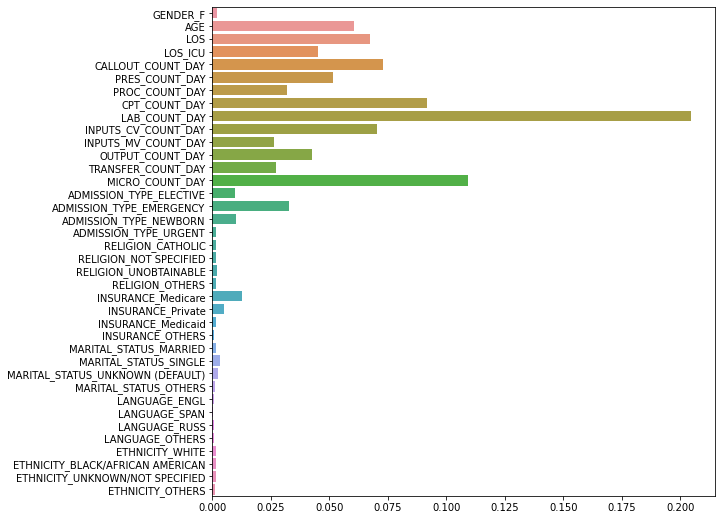

In [ ]:
plt.figure(figsize = (9, 9))
sns.barplot(x = model_rf2.feature_importances_, y = features_list)

### Saving and Loading your trained model

After training a model you might want to save your model to your Google Drive so that you do not need to re-train it next time. (As a side note, due to the random nature of most machine learning algorithms, if you did not set a `random_state` while training, you would end up with a model with different trained parameters when you re-train a model)

In [ ]:
import joblib

To save:

In [ ]:
joblib.dump(model_rf2, gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf2.joblib') # specify your filename here

['/content/gdrive/MyDrive/mimic_in_hosp_mortality_model_rf2.joblib']

To load:

In [ ]:
model_rf2_loaded = joblib.load(gdrive_rootpath + 'mimic_in_hosp_mortality_model_rf2.joblib') # specify your filename here

In [ ]:
model_rf2_loaded

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=300,
                       n_jobs=-1, random_state=1)

## Discussion

How well will the models above translate into a decision support system in practice? Here are some issues you may think about (which is beyond the scope of training machine learning models itself):

* What are the purposes or goals of the model? Do they align with the interests and focuses of clinicians, patients or other stakeholders? 
* Suppose we trained a reasonably reliable model. What could be the associated interventions based on the model predictions?
* What are the limitations of the model from an operational perspective? 
  * e.g. consider the time of which the variables becomes available. Could the model deliver the predictions in a timely manner? Can this be improved? 

# Example: Length of Stay Prediction

The purpose of this example is solely to demonstrate the codes for a regression problem instead of a classification problem. In actuality, using the following list of features is likely problematic as hospital stay-normalized variables such as `LAB_COUNT_DAY` is inherently calculated from `LOS`. 


## Setup

In [ ]:
# the only features excluded from the above are 'LOS' and 'LOS_ICU'
features_list_los = ['GENDER_F', 'AGE', 
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY', 
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS', 
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list_los)

36

In [ ]:
X_los = df[features_list_los]
y_los = df['LOS'] # new prediction target

## Train-test Split

In [ ]:
X_los_train, X_los_test, y_los_train, y_los_test = train_test_split(
    X_los, y_los, 
    test_size = 0.2,  # 20% of data belongs to the test set
    random_state = 1) # make sure the split is the same across different devices for illustrative purposes
# note that we do NOT stratify as the values of y are not categorical

In [ ]:
X_los_train.shape

(47180, 36)

In [ ]:
X_los_test.shape

(11796, 36)

## Training Random Forest Model

Note that we are using **`RandomForestRegressor()`** instead of `RandomForestClassifier()`. You can perform hypermeter tuning by using `GridSearchCV()` in the same way.

In [ ]:
model_rf_los = RandomForestRegressor(n_estimators = 200, 
                                     max_depth = 10,
                                     random_state = 1,
                                     n_jobs = -1)

In [ ]:
model_rf_los.fit(X_los_train, y_los_train)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1, random_state=1)

## Evaluation

Mean-squared-error and R<sup>2</sup> are two common metrics to report. A full list of available metrics could be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [ ]:
y_los_pred_rf = model_rf_los.predict(X_los_test)

In [ ]:
mean_squared_error(y_los_test, y_los_pred_rf)

27.891939094730702

In [ ]:
r2_score(y_los_test, y_los_pred_rf)

0.8275834797268249

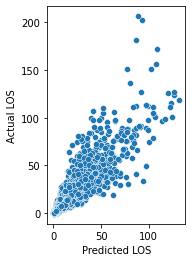

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect = 'equal')
sns.scatterplot(x = y_los_pred_rf, y = y_los_test)\
  .set(xlabel = 'Predicted LOS', ylabel = 'Actual LOS')

plt.show()

## Understanding the model

Variable importance is still applicable to regression problems if you are using a tree-based model. 

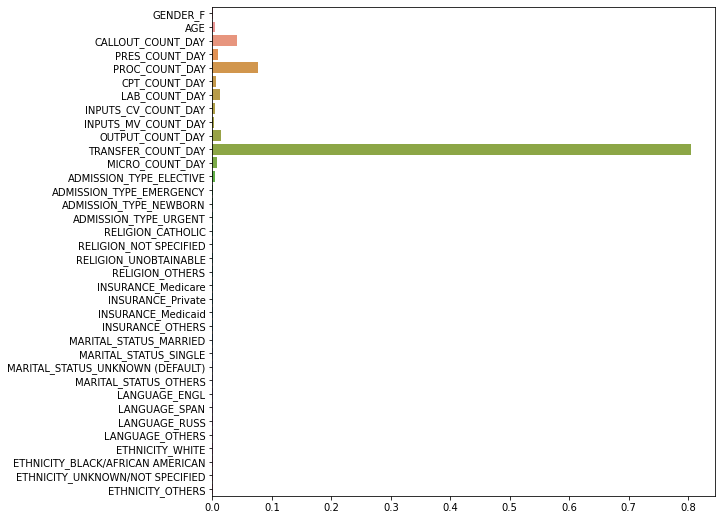

In [ ]:
plt.figure(figsize = (9, 9))
sns.barplot(x = model_rf_los.feature_importances_, y = features_list_los)

**Observations**

* From the actual against predicted graph, the model is fairly able to predict LOS below 100, but could not predict LOS accurately for those over 100.
* The variable importance plot could be an evidence of a variable `TRANSFER_COUNT_DAY` being systematically tied to LOS due to their uniquely strong association. 

# References

* [Which machine learning algorithm should I use?](https://blogs.sas.com/content/subconsciousmusings/2020/12/09/machine-learning-algorithm-use/)
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/04/machine-learning-cheet-sheet-2.png)
* [Decision Tree vs. Random Forest – Which Algorithm Should you Use?](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/)
* [Train/Test Split and Cross Validation in Python](https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6)
